In [68]:
# %%
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl
from utils.plot_utils import shiftedColorMap, template_reorder, get_gradient_colors
from utils.opto_utils import opto_metrics
from open_ephys.analysis import Session
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from spikeinterface.core.sorting_tools import random_spikes_selection
import pickle
import shutil
import datetime
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
from tqdm import tqdm
import spikeinterface.widgets as sw
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
from trimesh import load_mesh
from utils.ccf_utils import ccf_pts_convert_to_mm
from matplotlib.gridspec import GridSpec as gs
from scipy.signal import welch
from utils.plot_utils import combine_pdf_big
import numbers
%matplotlib inline


In [2]:
session = 'behavior_754897_2025-03-13_11-20-42'
data_type = 'curated'
target = 'soma'


In [71]:

session_dir = session_dirs(session)
unit_tbl = get_unit_tbl(session, data_type, summary=True)
we = si.load(session_dir['postprocessed_dir_curated'], load_extensions=False)
y_loc = we.get_extension('unit_locations').get_data()[:,1]


In [72]:

#     # %%
# unit_tbl = get_unit_tbl(session, data_type, summary=False)
# opto_tag = opto_metrics(session, data_type)
# unit_ids = unit_tbl['unit_id'].values.tolist()
# unit_ids = [int(unit_id) for unit_id in unit_ids]

# # %%
# p_max = []
# p_mean = []
# lat_max_p = []
# lat_mean = []
# euc_max_p = []
# corr_max_p = []
# bl_max_p = []
# pass_count = [] 
# # check if this session has a unit opto tagged at all by checking if resp_lat exists
# for unit_id in unit_ids:
#     curr_opto = opto_tag.load_unit(unit_id)
#     # find ones with respond latencies
#     sort_inds = np.argsort(curr_opto['resp_p_bl'].values)[::-1]
#     for curr_ind in sort_inds:
#         curr_max_p = curr_opto['resp_p_bl'].values[curr_ind]
#         if not curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].isna().all():
#             break
#     if curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].isna().all():
#         curr_max_p = curr_opto['resp_p_bl'].max()

#     p_max.append(curr_max_p)
#     p_max_ind = curr_opto['resp_p_bl'].idxmax()
#     max_conditions = curr_opto[curr_opto['resp_p_bl']==curr_max_p]
#     # count number of cases that passes the threshold, group by power, pre-post and duration
#     count = curr_opto.groupby(['powers', 'stim_times', 'durations']).agg({'resp_p_bl': list})
#     count = count.reset_index()
#     count = pd.DataFrame(count)
#     count_curr_all = []
#     for row in count.iterrows():
#         count_curr = np.sum(np.array(row[1]['resp_p_bl']) >= 0.3)
#         count_curr_all.append(count_curr)
#     pass_count.append(np.max(count_curr_all))

#     p_mean.append(np.nanmax(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['mean_p'].values))

#     lat_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['resp_lat'].values))
#     lat_mean.append(curr_opto['resp_lat'].mean(skipna=True))
#     if np.all(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['euclidean_norm'].values == None):
#         euc_max_p.append(np.nan)
#         corr_max_p.append(np.nan)
#     else:
#         euc_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['euclidean_norm'].values))
#         corr_max_p.append(np.nanmin(curr_opto[curr_opto['resp_p_bl'] == curr_max_p]['correlation'].values))
#     bl_max_p.append(curr_opto.loc[p_max_ind]['resp_p'] - curr_opto.loc[p_max_ind]['resp_p_bl'])
# peak_channel = [np.argmax(np.abs(temp[90,:])) for temp in unit_tbl['waveform_mean']]
# peak_index = [np.argmin(temp[:, peakC]) for temp, peakC in zip(unit_tbl['waveform_mean'], peak_channel)]
# peak_wf = [temp[90-30:90+60, peak_C] for temp, peak_C in zip(unit_tbl['waveform_mean'], peak_channel)]
# peak_wf_aligned = [
#     np.concatenate((
#         np.full(max(30 - peak_ind, 0), np.nan),
#         temp[max(peak_ind - 30, 0) : min(peak_ind + 60, temp.shape[0]), peak_C],
#         np.full(max((peak_ind + 60) - temp.shape[0], 0), np.nan)
#     ))
#     for temp, peak_ind, peak_C in zip(unit_tbl['waveform_mean'], peak_index, peak_channel)
# ]

# amp = [np.max(temp[:, peak_C]) - np.min(temp[:, peak_C]) for temp, peak_C in zip(unit_tbl['waveform_mean'], peak_channel)]
# peak = [temp[90,peak_C] for temp, peak_C in zip(unit_tbl['waveform_mean'], peak_channel)]
# label = unit_tbl['decoder_label'].values
# real_unit = label != 'artifact'
# opto_tag_tbl = pd.DataFrame({'unit_id': unit_ids, 
#                             'bl_max_p': bl_max_p,
#                             'p_max': p_max, 
#                             'p_mean': p_mean, 
#                             'lat_max_p': lat_max_p, 
#                             'lat_mean': lat_mean, 
#                             'euc_max_p': euc_max_p, 
#                             'corr_max_p': corr_max_p, 
#                             'opto_pass': unit_tbl['opto_pass'].values,
#                             'amp': amp, 
#                             'peak': peak,
#                             'real_unit': real_unit,
#                             'y_loc': y_loc, 
#                             'pass_count': pass_count,
#                             })

# unit_tbl_tmp = unit_tbl.copy()
# unit_tbl_tmp.drop(columns=opto_tag_tbl.columns.difference(['unit_id']), inplace=True, errors='ignore')
# unit_tbl_tmp['peak_wf'] = peak_wf
# unit_tbl_tmp['peak_wf_aligned'] = peak_wf_aligned
# unit_tbl_tmp['wf_2d'] = wf_2d
# opto_tag_tbl_summary = pd.merge(opto_tag_tbl, unit_tbl_tmp, on='unit_id')


Text(0.5, 1.0, 'counts')

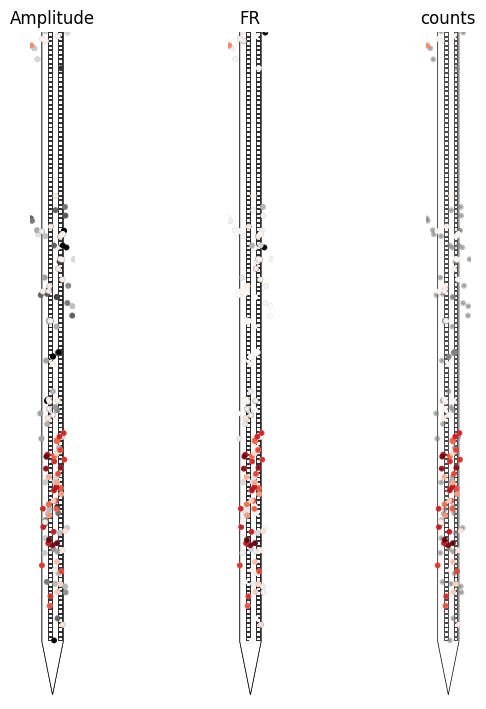

In [73]:
unit_ids = we.sorting.unit_ids
fig = plt.figure(figsize=(20, 10))
gs_probe = gridspec.GridSpec(2, 8, figure=fig, height_ratios=[1, 20])
# amplitude
ax = fig.add_subplot(gs_probe[1, 0])
colors, norm, cmap = get_gradient_colors(unit_tbl['amp'].values, ceiling=200, cmap_name='Grays')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids, unit_colors=color_dict, ax = ax, hide_axis=True)

unit_ids_filtered = pd.Series(unit_ids)[unit_tbl['real_unit'] & (unit_tbl['lat_mean']>=0.007) & (unit_tbl['euc_max_p']<=0.3)].values.tolist()
colors, norm, cmap = get_gradient_colors(unit_tbl['p_mean'].values, ceiling=0.8, cmap_name='Reds')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax, hide_axis=True)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('Amplitude')

# fr
ax = fig.add_subplot(gs_probe[1, 1])
colors, norm, cmap = get_gradient_colors(unit_tbl['firing_rate'].values, ceiling=20, cmap_name='Grays')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids, unit_colors=color_dict, ax = ax, hide_axis=True)

unit_ids_filtered = pd.Series(unit_ids)[unit_tbl['real_unit'] & (unit_tbl['lat_mean']>=0.007) & (unit_tbl['euc_max_p']<=0.3)].values.tolist()
colors, norm, cmap = get_gradient_colors(unit_tbl['p_mean'].values, ceiling=0.8, cmap_name='Reds')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax, hide_axis=True)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('FR')

# fr
ax = fig.add_subplot(gs_probe[1, 2])

# w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids, ax = ax, hide_axis=True)

unit_ids_filtered = pd.Series(unit_ids)[unit_tbl['real_unit'] & (unit_tbl['lat_mean']>=0.007) & (unit_tbl['euc_max_p']<=0.3)].values.tolist()
colors, norm, cmap = get_gradient_colors(unit_tbl['p_mean'].values, ceiling=0.8, cmap_name='Reds')
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax, hide_axis=True)
w.ax.set_ylim(-200, 2000)
w.ax.set_title('counts')


In [19]:
# in ccf space
# load combined_unit_tbl
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units_filtered = combined_tagged_units[combined_tagged_units['session'] == session]
# load mesh
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)
mesh_vertices_mm[:, 2] = -np.abs(mesh_vertices_mm[:, 2])  # Mirror ML to left
blue_white_red = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0, 'blue'), (0.5, 'white'), (1.0, 'red')]
)
ml, ap, dv = 2, 0, 1
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

In [75]:
animal_id = '754897'
filter = [animal_id in s for s in combined_tagged_units['session']]
combined_tagged_units_filtered = combined_tagged_units[filter]
len(combined_tagged_units_filtered)
filter = (combined_tagged_units['decoder'] != 'artifact') & (combined_tagged_units['decoder'] != 'noise')
# combined_tagged_units_filtered = combined_tagged_units[filter]

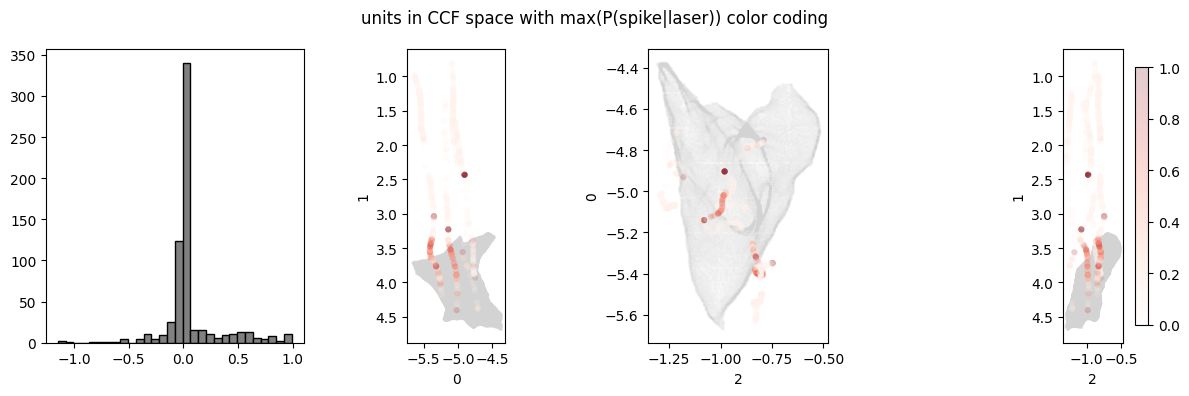

In [76]:

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
features = ['amp', 'firing_rate']
color_code_filtered = combined_tagged_units_filtered['p_mean'].values
ax = axes[0]
# Plot histogram of color code
ax.hist(color_code_filtered[~np.isnan(color_code_filtered)], bins=30, color='gray', edgecolor='black')
# top_90 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.95)
# bottom_10 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.05)
# ax.axvline(top_90, color='red', linestyle='--', linewidth=1)
# ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
color_code_nl = color_code_filtered.copy()
color_code_nl = (color_code_nl - 0) / (np.nanmax(color_code_filtered)-0)  # Normalize color code to [0, 1] using 10-90% quantiles
color_code_nl[color_code_nl < 0] = 0
color_code_nl[color_code_nl > 1] = 1
x_ccf = combined_tagged_units_filtered['x_ccf'].values
y_ccf = combined_tagged_units_filtered['y_ccf'].values
z_ccf = combined_tagged_units_filtered['z_ccf'].values
ccfs = np.column_stack((x_ccf, y_ccf, z_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)
ccfs[:, 2] = -np.abs(ccfs[:, 2])  # Mirror ML to left
for plane, ax in zip(planes.keys(), axes[1:]):
    # Plot the mesh
    ax.scatter(mesh_vertices_mm[:, planes[plane][0]], mesh_vertices_mm[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.1)
    # Plot the points
    sc = ax.scatter(ccfs[:, planes[plane][0]], ccfs[:, planes[plane][1]], c=color_code_nl, cmap='Reds', s=20, edgecolor='none', alpha=0.2)
    # if plane == 'hor':
    #     ax.set_title(feature)
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    # set equal aspect ratio
    ax.set_aspect('equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    if plane == 'cor':
        fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
plt.suptitle(f'units in CCF space with max(P(spike|laser)) color coding')
plt.tight_layout()
plt.savefig(f'/root/capsule/scratch/combined/ccf_maps/{animal_id}_units_ccf_opto_tag.png', dpi=300)

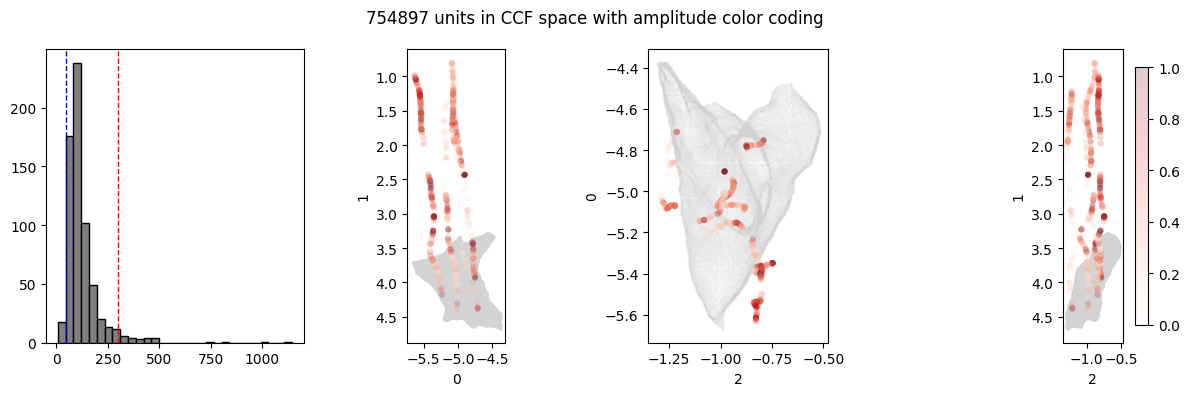

In [77]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
features = ['amp', 'firing_rate']
color_code_filtered = combined_tagged_units_filtered['amp'].values
ax = axes[0]
# Plot histogram of color code
ax.hist(color_code_filtered[~np.isnan(color_code_filtered)], bins=30, color='gray', edgecolor='black')
# top_90 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.95)
# bottom_10 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.05)
# ax.axvline(top_90, color='red', linestyle='--', linewidth=1)
# ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
color_code_nl = color_code_filtered.copy()
color_code_nl = (color_code_nl - 50) / (200-50)  # Normalize color code to [0, 1] using 10-90% quantiles
color_code_nl[color_code_nl < 0] = 0
color_code_nl[color_code_nl > 1] = 1
ax.axvline(50, color='blue', linestyle='--', linewidth=1)
ax.axvline(300, color='red', linestyle='--', linewidth=1)
x_ccf = combined_tagged_units_filtered['x_ccf'].values
y_ccf = combined_tagged_units_filtered['y_ccf'].values
z_ccf = combined_tagged_units_filtered['z_ccf'].values
ccfs = np.column_stack((x_ccf, y_ccf, z_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)
ccfs[:, 2] = -np.abs(ccfs[:, 2])  # Mirror ML to left
for plane, ax in zip(planes.keys(), axes[1:]):
    # Plot the mesh
    ax.scatter(mesh_vertices_mm[:, planes[plane][0]], mesh_vertices_mm[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
    # Plot the points
    sc = ax.scatter(ccfs[:, planes[plane][0]], ccfs[:, planes[plane][1]], c=color_code_nl, cmap='Reds', s=20, edgecolor='none', alpha=0.2)
    # if plane == 'hor':
    #     ax.set_title(feature)
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    # set equal aspect ratio
    ax.set_aspect('equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    if plane == 'cor':
        fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
plt.suptitle(f'{animal_id} units in CCF space with amplitude color coding')
plt.tight_layout()

NameError: name 'combined_tagged_units_filtered' is not defined

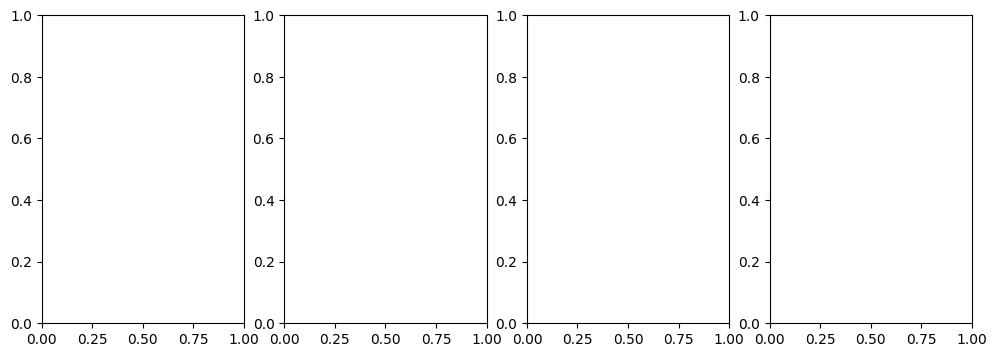

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
color_code_filtered = combined_tagged_units_filtered['fr'].values
ax = axes[0]
# Plot histogram of color code
ax.hist(color_code_filtered[~np.isnan(color_code_filtered)], bins=30, color='gray', edgecolor='black')
# top_90 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.95)
# bottom_10 = np.quantile(color_code_filtered[~np.isnan(color_code_filtered)], 0.05)
# ax.axvline(top_90, color='red', linestyle='--', linewidth=1)
# ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
color_code_nl = color_code_filtered.copy()
color_code_nl = (color_code_nl - 0) / (10)  # Normalize color code to [0, 1] using 10-90% quantiles
color_code_nl[color_code_nl < 0] = 0
color_code_nl[color_code_nl > 1] = 1
x_ccf = combined_tagged_units_filtered['x_ccf'].values
y_ccf = combined_tagged_units_filtered['y_ccf'].values
z_ccf = combined_tagged_units_filtered['z_ccf'].values
ccfs = np.column_stack((x_ccf, y_ccf, z_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)
ccfs[:, 2] = -np.abs(ccfs[:, 2])  # Mirror ML to left
for plane, ax in zip(planes.keys(), axes[1:]):
    # Plot the mesh
    ax.scatter(mesh_vertices_mm[:, planes[plane][0]], mesh_vertices_mm[:, planes[plane][1]], color='lightgray', alpha=0.1, s = 0.2)
    # Plot the points
    sc = ax.scatter(ccfs[:, planes[plane][0]], ccfs[:, planes[plane][1]], c=color_code_nl, cmap='Reds', s=20, edgecolor='none', alpha=0.2)
    # if plane == 'hor':
    #     ax.set_title(feature)
    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    # set equal aspect ratio
    ax.set_aspect('equal')
    if planes[plane][1] == dv:
        ax.invert_yaxis()
    if plane == 'cor':
        fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
plt.suptitle(f'{animal_id} units in CCF space with firing rate color coding')
plt.tight_layout()

In [88]:
def plot_raw_psd_corr(recording, start_frames, pre_chunk_size_second = 1, post_chunk_size_second=3, plot=True, freq_cut = [None, 300]):
        
    # each power level, select 5 random start times, calculate mean power spectrum
    fig = plt.figure(figsize=(15, 15))
    gs_psd = gs(nrows=4, ncols=len(start_frames)+1,  height_ratios=[2, 1, 2, 2], width_ratios=[1] * (len(start_frames)+1))
    all_data = 0
    all_psd = 0
    all_corr = 0

    for bin_ind in range(len(start_frames)):
        # print(bin_ind)
        start_frame = int(np.round(start_frames[bin_ind])) - int(np.round(pre_chunk_size_second*recording.get_sampling_frequency()))
        start_frame = max(start_frame, 0)  # Ensure start_frame is not negative
        end_frame_all = start_frame + (pre_chunk_size_second + post_chunk_size_second)*recording.get_sampling_frequency()
        if end_frame_all > recording.get_num_frames():
            end_frame_all = recording.get_num_frames()
            start_frame = end_frame_all - (pre_chunk_size_second + post_chunk_size_second)*recording.get_sampling_frequency()
        data = recording.get_traces(start_frame=start_frame,
                            end_frame=end_frame_all,
                            return_scaled=True)

        if not isinstance(all_data, (int, float)) :
                if (np.shape(data)[0] != np.shape(all_data)[0]):
                        if (np.shape(data)[0] - np.shape(all_data)[0] > 0) and (np.shape(data)[0] - np.shape(all_data)[0] < 0.01*(pre_chunk_size_second + post_chunk_size_second)*recording.get_sampling_frequency()):
                                data = data[:np.shape(all_data)[0], :]
                        elif (np.shape(data)[0] - np.shape(all_data)[0] < 0) and (np.shape(all_data)[0] - np.shape(data)[0] < 0.01*(pre_chunk_size_second + post_chunk_size_second)*recording.get_sampling_frequency()):
                                all_data = all_data[:np.shape(data)[0], :]
                        else:
                                raise ValueError(f"Data shape mismatch: {np.shape(data)} vs {np.shape(all_data)}")
                
        all_data = all_data + data
        corr = np.corrcoef(data.T)
        np.fill_diagonal(corr, 0)  # Fill diagonal with 0 to avoid self-correlation
        all_corr = all_corr + corr
        if plot:
                ax = fig.add_subplot(gs_psd[-1, bin_ind])
                vmax = np.nanmax(np.abs(corr))
                vmin = -vmax
                ax.imshow(
                        corr,
                        extent=[0, data.shape[1], 0, data.shape[1]],
                        aspect='auto',
                        origin='lower',
                        cmap='bwr',
                        interpolation='none',
                        vmin=vmin,
                        vmax=vmax
                )
                ax.set_xlabel('Channel')
                ax.set_ylabel('Channel')
        
                # time = np.linspace(start_time, end_time, data.shape[0])
                ax = fig.add_subplot(gs_psd[0, bin_ind])

                ax.imshow(
                        data.T,
                        extent=[-pre_chunk_size_second, post_chunk_size_second, 0, data.shape[1]],
                        aspect='auto',
                        origin='lower',
                        cmap='gray',
                        vmin=-50,
                        vmax=50,
                        interpolation='none'
                )

                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Channel')

        # data = data.reshape(-1, 1)  # Ensure data is in the correct shape for plotting
        frequencys, psd = welch(data.T, fs=recording.get_sampling_frequency(), nperseg=8096)
        all_psd = all_psd + psd
        if plot:
                ax = fig.add_subplot(gs_psd[1, bin_ind])
                ax.imshow(X=np.log(psd), 
                        extent=[frequencys[0], frequencys[-1], 0, data.shape[1]],
                        aspect='auto',
                        origin='lower',
                        cmap='viridis',
                        interpolation='none'
                )
                ax.set_xlim(freq_cut[0], freq_cut[1])
                plt.autoscale(axis='y')
                ax.set_xlabel('Frequency (Hz)')
                ax.set_ylabel('Channel')
                ax.set_title('Log(PSD)')

                ax = fig.add_subplot(gs_psd[2, bin_ind])
                ax.loglog(frequencys, psd.T, 
                        color='black', 
                        alpha=0.3, 
                        linewidth=0.1
                )
                ax.set_xlim(freq_cut[0], freq_cut[1])
                plt.autoscale(axis='y')
                ax.set_xlabel('Log(Frequency (Hz))')
                ax.set_ylabel('Log(psd)')


    mean_signal = all_data/len(start_frames)
    mean_psd = all_psd/len(start_frames)
    mean_corr = all_corr/len(start_frames)
    frame_time = np.linspace(-pre_chunk_size_second, post_chunk_size_second, np.shape(mean_signal)[0])
    # remove baseline
    mean_signal = mean_signal - np.mean(mean_signal[frame_time<=0], axis=0, keepdims=True)
    if plot:
        ax = fig.add_subplot(gs_psd[0, -1])
        ax.imshow(
                mean_signal.T,
                extent=[-pre_chunk_size_second, post_chunk_size_second, 0, mean_signal.shape[1]],
                aspect='auto',
                origin='lower',
                cmap='gray',
                vmin=-50,
                vmax=50,
                interpolation='none'
        )

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Channel')
        ax.set_title('Mean Signal') 
        ax = fig.add_subplot(gs_psd[1, -1])

        ax.imshow(X=np.log(mean_psd), 
                extent=[frequencys[0], frequencys[-1], 0, mean_signal.shape[1]],
                aspect='auto',
                origin='lower',
                cmap='viridis',
                interpolation='none'
        )

        ax.set_xlim(freq_cut[0], freq_cut[1])
        plt.autoscale(axis='y')
        ax.set_xlabel('Frequency (Hz)')

        ax.set_ylabel('Channel')
        ax.set_title('Log(PSD)')

        ax = fig.add_subplot(gs_psd[2, -1])
        ax.loglog(frequencys, mean_psd.T, 
                color='black', 
                alpha=0.3, 
                linewidth=0.1
        )
        ax.set_xlim(freq_cut[0], freq_cut[1])
        plt.autoscale(axis='y')
        ax.set_xlabel('Log(Frequency (Hz))')
        ax.set_ylabel('Log(psd)')

        ax = fig.add_subplot(gs_psd[-1, -1])
        vmax = np.nanmax(np.abs(mean_corr))
        vmin = -vmax
        ax.imshow(
                mean_corr,
                extent=[0, mean_signal.shape[1], 0, mean_signal.shape[1]],
                aspect='auto',
                origin='lower',
                cmap='bwr',
                interpolation='none',
                vmin=vmin,
                vmax=vmax
        )
        ax.set_xlabel('Channel')
        ax.set_ylabel('Channel')
        ax.set_title('Correlation Matrix')

        plt.suptitle(f'Power Spectrum Density')
        plt.tight_layout()

    return fig, mean_signal, mean_psd, mean_corr, frequencys


In [21]:
def plot_ephys_probe(session, data_type='curated', probe = '2', plot_raw = False):   
    # load data
    session_dir = session_dirs(session)
    with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
        combined_tagged_units = pickle.load(f)
    stream_name = 'ProbeA'
    recording_zarr = [os.path.join(session_dir['session_dir_raw'], f) for f in os.listdir(session_dir['session_dir_raw']) if stream_name in f and 'LFP' not in f][0]
    recording = si.read_zarr(recording_zarr)
    # load the LFP data 
    if probe == '2':
        recording_LFP = spre.bandpass_filter(recording, freq_min=1, freq_max=300)
        recording_LFP = spre.common_reference(recording_LFP, reference='global', operator='median')
    elif probe == 'opto':
        recording_LFP_zarr = [os.path.join(session_dir['session_dir_raw'], f) for f in os.listdir(session_dir['session_dir_raw']) if stream_name in f and 'LFP' in f][0]
        recording_LFP = si.read_zarr(recording_LFP_zarr)
        recording_LFP = spre.common_reference(recording_LFP, reference='global', operator='median')    
    # load whole data
    recording = spre.bandpass_filter(recording, freq_min=300, freq_max=10000)
    recording = spre.common_reference(recording, reference='global', operator='median')
    # load the opto file
    opto_tbl = pd.read_csv(os.path.join(session_dir['opto_dir_curated'], f'{session}_opto_session_soma.csv'))
    # select 5 randoms blocks, calculate mean power specturm as baseline
    if len(opto_tbl['pre_post'].unique()) > 1:
        range_bh = [opto_tbl[opto_tbl['pre_post'] == 'pre']['laser_onset_samples'].max(), 
                    opto_tbl[opto_tbl['pre_post'] == 'post']['laser_onset_samples'].min()]
    else:
        range_bh = [0, opto_tbl['laser_onset_samples'].min()]
    # plot baseline high-freq
    num_bins = 5
    time_frames = np.linspace(range_bh[0], range_bh[1], num_bins + 1)
    time_frames_rec = time_frames*recording.get_sampling_frequency()/30000
    fig, mean_signal, mean_psd, mean_corr, frequencys = plot_raw_psd_corr(recording, time_frames_rec, pre_chunk_size_second=0, post_chunk_size_second=2, plot=plot_raw, freq_cut=[300, 10000])
    fig.suptitle(f"{session} Power Spectrum Density (bl)_300-10000", fontsize=16)
    fig.savefig(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_power_spectrum_density_bl_300-10000.png'), dpi=300)
    # plot baseline low-freq
    time_frames_rec = time_frames*recording_LFP.get_sampling_frequency()/30000
    fig, mean_signal_LFP, mean_psd_LFP, mean_corr_LFP, frequencys = plot_raw_psd_corr(recording_LFP, time_frames_rec, pre_chunk_size_second=0, post_chunk_size_second=2, plot=plot_raw, freq_cut=[1, 300])
    fig.suptitle(f"{session} Power Spectrum Density (bl)_1-300 LFP", fontsize=16)
    fig.savefig(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_power_spectrum_density_bl_1-300_LFP.png'), dpi=300)

    # plot opto high-freq
    time_frames = np.random.choice(opto_tbl[opto_tbl['power']==opto_tbl['power'].max()]['laser_onset_samples'].values, size=num_bins, replace=False)  # convert to samples
    time_frames_rec = time_frames*recording.get_sampling_frequency()/30000
    fig, mean_signal_opto, mean_psd_opto, mean_corr_opto, frequencys_opto = plot_raw_psd_corr(recording, time_frames_rec, pre_chunk_size_second=-0.5, post_chunk_size_second=1, plot=plot_raw, freq_cut=[300, 10000])
    fig.suptitle(f"{session} Power Spectrum Density (Opto)_300-10000", fontsize=16)
    fig.savefig(fname=os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_power_spectrum_density_opto_300-10000.png'), dpi=300)
    # plot opto low-freq
    time_frames_rec = time_frames*recording_LFP.get_sampling_frequency()/30000
    fig, mean_signal_opto_LFP, mean_psd_opto_LFP, mean_corr_opto_LFP, frequencys_opto_LFP = plot_raw_psd_corr(recording_LFP, time_frames_rec, pre_chunk_size_second=-0.5, post_chunk_size_second=1, plot=plot_raw, freq_cut=[1, 300])
    fig.suptitle(f"{session} Power Spectrum Density (Opto)_1-300 LFP", fontsize=16)
    fig.savefig(fname=os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_power_spectrum_density_opto_1-300_LFP.png'), dpi=300)

    # Compute the difference
    # diff = np.log(mean_psd_opto/np.sum(mean_psd_opto, 1).reshape(-1, 1)) - np.log(mean_psd/np.sum(mean_psd, 1).reshape(-1, 1))

    curr_unit_tbl = combined_tagged_units[combined_tagged_units['session'] == session]
    curr_unit_tbl = curr_unit_tbl[(curr_unit_tbl['decoder'] != 'artifact') & (curr_unit_tbl['decoder'] != 'noise')]

    fig = plt.figure(figsize=(40, 8))
    gs_cmp = gridspec.GridSpec(1, 12, figure=fig, width_ratios=[2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1])
    # Get consistent y-axis range (number of channels)
    y_max = mean_signal.shape[1]
    ylim = (0, y_max)

    # Left subplot
    diff = np.log(mean_psd_opto_LFP) - np.log(mean_psd_LFP)
    # Find symmetric color limits around 0
    vmax = np.nanmax(np.abs(diff))
    vmin = -vmax
    
    ax1 = fig.add_subplot(gs_cmp[0])
    im1 = ax1.imshow(diff, 
                    extent=[frequencys[0], frequencys[-1], 0, y_max],
                    aspect='auto',
                    origin='lower',
                    cmap='bwr',
                    vmin=vmin,
                    vmax=vmax,
                    interpolation='none')
    ax1.set_xlim(frequencys[0], 300)
    ax1.set_ylim(ylim)
    plt.colorbar(im1, ax=ax1, label='log(P_opto / P)')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Channel')
    ax1.set_title('Log(P_opto / P) - Low freq')

    # Middle subplot
    ax2 = fig.add_subplot(gs_cmp[1])
    vmax = np.nanmax(np.abs(mean_corr_LFP))
    vmin = -vmax
    im2 = ax2.imshow(mean_corr_LFP,
                        extent=[0, mean_signal.shape[1], 0, mean_signal.shape[1]],
                        aspect='auto',
                        origin='lower',
                        cmap='bwr',
                        vmin=vmin,
                        vmax=vmax,
                        interpolation='none')
    ax2.set_xlabel('Channel')
    ax2.set_ylabel('Channel')
    ax2.set_title('Correlation Matrix')
    plt.colorbar(im2, ax=ax2, label='Correlation Coefficient')

    # Right subplot (scatter)
    ax3 = fig.add_subplot(gs_cmp[2])
    rand_value = np.random.uniform(low=-1, high=1, size=len(curr_unit_tbl))
    im3 = ax3.scatter(rand_value,
                curr_unit_tbl['peak_channel_ind'], 
                c=curr_unit_tbl['p_max'], 
                cmap='Reds', 
                s=20, 
                edgecolor='none', 
                vmin=0,
                vmax = 0.8,
                alpha=0.5)
    ax3.set_ylim(ylim)
    ax3.set_xlabel('Random number for visualization')
    ax3.set_xlabel('Arbitrary horizontal')
    ax3.set_ylabel('Channel')
    plt.colorbar(im3, ax=ax3, label='p_max')

    ax4 = fig.add_subplot(gs_cmp[3])
    diff = mean_corr_opto_LFP - mean_corr_LFP
    vmax = np.nanmax(np.abs(diff))
    vmin = -vmax
    im4 = ax4.imshow(diff, 
                    extent=[0, mean_signal.shape[1], 0, mean_signal.shape[1]],
                    aspect='auto',
                    origin='lower',
                    cmap='bwr',
                    vmin=vmin,
                    vmax=vmax,
                    interpolation=None)
    
    ax4.set_xlabel('Channel')
    ax4.set_ylabel('Channel')
    ax4.set_title('Correlation Difference')
    plt.colorbar(im4, ax=ax4, label='Correlation Difference')

    ax5 = fig.add_subplot(gs_cmp[4])
    im5 = ax5.scatter(rand_value,
                curr_unit_tbl['peak_channel_ind'], 
                c=curr_unit_tbl['amp'], 
                cmap='Reds', 
                s=20, 
                vmin=20,
                vmax=500,
                edgecolor='none', 
                alpha=0.5)
    ax5.set_ylim(ylim)
    ax5.set_xlabel('Random number for visualization')
    ax5.set_ylabel('Channel')
    plt.colorbar(im5, ax=ax5, label='Amplitude')

    # raw trace:

    # plot baseline
    num_bins = 10
    time_frames = np.random.choice(opto_tbl[opto_tbl['power']==opto_tbl['power'].max()]['laser_onset_samples'].values, size=num_bins, replace=False)  # convert to samples
    post_chunk_size_second = 1 # seconds
    pre_chunk_size_second = 0.5 # seconds

    # for each timeframe, extract the LFP data and concatenate them
    all_LFP = 0

    for frame_ind in range(len(time_frames)):
        start_frame = int(np.round(time_frames[frame_ind])) - int(pre_chunk_size_second * recording.get_sampling_frequency())
        start_frame_LFP = int(np.round(start_frame*recording_LFP.get_sampling_frequency() / recording.get_sampling_frequency()))
        end_frame_LFP = start_frame_LFP + (post_chunk_size_second+pre_chunk_size_second)*recording_LFP.get_sampling_frequency()
        end_frame_LFP = min(end_frame_LFP, recording_LFP.get_num_samples())
        frame_time = np.linspace(-pre_chunk_size_second, post_chunk_size_second, int(end_frame_LFP - start_frame_LFP))
        data_LFP = recording_LFP.get_traces(start_frame=start_frame_LFP,
                                end_frame=end_frame_LFP,
                                return_scaled=True)
        # remove data 0 - 5 ms
        pulse = 5
        ipi = 0.2
        pulse_starts = np.arange(0, post_chunk_size_second, ipi)
        pulse_ends = pulse_starts + 0.005
        mean_bl = np.mean(data_LFP[frame_time <= 0, :], axis=0)
        data_LFP = data_LFP - mean_bl  # subtract baseline
        mean_bl = np.mean(data_LFP[frame_time <= 0, :], axis=0)  # recalculate mean baseline after subtracting
        # remove opto artifacts
        for pulse_ind in range(pulse):
            pulse_range = (frame_time >= pulse_starts[pulse_ind]) & (frame_time < pulse_ends[pulse_ind])
            data_LFP[pulse_range, :] = mean_bl
        all_LFP = all_LFP + data_LFP

    mean_LFP = all_LFP / len(time_frames)


    ax6 = fig.add_subplot(gs_cmp[5])
    im = ax6.imshow(mean_LFP.T, 
            extent=[-pre_chunk_size_second, post_chunk_size_second, 0, mean_LFP.shape[1]],
            aspect='auto',
            origin='lower',
            cmap='gray',
            interpolation='none',
            vmin = -50,
            vmax = 50,
            )
    plt.colorbar(im, label='Amplitude (uV)')

    
    # fr
    ax9 = fig.add_subplot(gs_cmp[6])
    im9 = ax9.scatter(rand_value,
                curr_unit_tbl['peak_channel_ind'], 
                c=curr_unit_tbl['fr'], 
                cmap='Reds', 
                s=20, 
                vmin=0,
                vmax=20,
                edgecolor='none', 
                alpha=0.5)
    ax9.set_ylim(ylim)
    plt.colorbar(im9, ax=ax9, label='Firing Rate (Hz)')

    # licks
    
    ili_thresh = 1
    unit_tbl = get_unit_tbl(session, data_type)
    if session_dir['nwb_beh'] is not None and os.path.exists(session_dir['nwb_beh']):
        nwb = load_nwb_from_filename(session_dir['nwb_beh'])
        lick_L = nwb.acquisition['left_lick_time'].timestamps[:]
        lick_R = nwb.acquisition['right_lick_time'].timestamps[:]
        # combine L and R
        licks = np.concatenate((lick_L, lick_R))
        licks = np.sort(licks, axis=0)

        # find train starts
        train_starts = licks[np.where(np.diff(licks) > ili_thresh)[0] + 1]
        train_starts_L = licks[np.where(np.diff(lick_L) > ili_thresh)[0] + 1]
        train_starts_R = licks[np.where(np.diff(lick_R) > ili_thresh)[0] + 1]
        session_tbl = nwb.trials.to_dataframe()
        choice_L = session_tbl[session_tbl['animal_response'] == 0]['reward_outcome_time'].values
        choice_R = session_tbl[session_tbl['animal_response'] == 1]['reward_outcome_time'].values

        go_cue_time = session_tbl['goCue_start_time'].values

        lick_ratio = np.full(len(curr_unit_tbl), np.nan, dtype=float)
        lick_L = np.full(len(curr_unit_tbl), np.nan, dtype=float)
        L_R_choice = np.full(len(curr_unit_tbl), np.nan, dtype=float)
        go_ratio = np.full(len(curr_unit_tbl), np.nan, dtype=float)

        for unit_ind, unit in enumerate(curr_unit_tbl['unit'].values):
            spike_times = unit_tbl[unit_tbl['unit_id'] == unit]['spike_times'].values[0]

            # lick response
            df_bl = align.to_events(spike_times, train_starts, (-1, -0.5), return_df=True)
            df_lick = align.to_events(spike_times, train_starts, (0, 0.5), return_df=True)
            bl_counts = np.zeros(len(train_starts))
            resp_counts = np.zeros(len(train_starts))
            for i in range(len(train_starts)):
                bl_counts[i] = len(df_bl[df_bl['event_index'] == i])/0.5
                resp_counts[i] = len(df_lick[df_lick['event_index'] == i])/0.5
            lick_ratio[unit_ind] = np.mean((resp_counts-bl_counts) / (resp_counts + bl_counts + 1e-6))

            # side bias
            df_bl_L = align.to_events(spike_times, train_starts_L, (-1, -0.5), return_df=True)
            df_bl_R = align.to_events(spike_times, train_starts_R, (-1, -0.5), return_df=True)
            df_lick_L = align.to_events(spike_times, train_starts_L, (0, 0.5), return_df=True)
            df_lick_R = align.to_events(spike_times, train_starts_R, (0, 0.5), return_df=True)
            
            bl_counts_L = np.zeros(len(train_starts_L))
            bl_counts_R = np.zeros(len(train_starts_R))
            resp_counts_L = np.zeros(len(train_starts_L))
            resp_counts_R = np.zeros(len(train_starts_R))

            for i in range(len(train_starts_L)):
                bl_counts_L[i] = len(df_bl_L[df_bl_L['event_index'] == i])/0.5
                resp_counts_L[i] = len(df_lick_L[df_lick_L['event_index'] == i])/0.5
            for i in range(len(train_starts_R)):
                bl_counts_R[i] = len(df_bl_R[df_bl_R['event_index'] == i])/0.5
                resp_counts_R[i] = len(df_lick_R[df_lick_R['event_index'] == i])/0.5
            lick_L[unit_ind] = np.mean((resp_counts_L-bl_counts_L) / (resp_counts_L + bl_counts_L + 1e-6)) - np.mean((resp_counts_R-bl_counts_R) / (resp_counts_R + bl_counts_R + 1e-6))

            # L/R choice
            df_choice_L = align.to_events(spike_times, choice_L, (0, 0.5), return_df=True)
            df_choice_R = align.to_events(spike_times, choice_R, (0, 0.5), return_df=True)
            choice_L_counts = np.zeros(len(choice_L))
            choice_R_counts = np.zeros(len(choice_R))
            for i in range(len(choice_L)):
                choice_L_counts[i] = len(df_choice_L[df_choice_L['event_index'] == i])/0.5
            for i in range(len(choice_R)):
                choice_R_counts[i] = len(df_choice_R[df_choice_R['event_index'] == i])/0.5
            L_R_choice[unit_ind] = (np.mean(choice_L_counts) - np.mean(choice_R_counts))/(np.mean(choice_L_counts) + np.mean(choice_R_counts) + 1e-6)

            # go cue
            df_go_cue = align.to_events(spike_times, go_cue_time, (0, 0.5), return_df=True)
            df_bl = align.to_events(spike_times, go_cue_time, (-1, 0), return_df=True)
            go_cue_counts = np.zeros(len(go_cue_time))
            bl_counts = np.zeros(len(go_cue_time))
            for i in range(len(go_cue_time)):
                go_cue_counts[i] = len(df_go_cue[df_go_cue['event_index'] == i])/0.5
                bl_counts[i] = len(df_bl[df_bl['event_index'] == i])/1
            go_ratio[unit_ind] = np.mean((go_cue_counts - bl_counts) / (go_cue_counts + bl_counts + 1e-6))


        
        ax7 = fig.add_subplot(gs_cmp[7])
        im7 = ax7.scatter(rand_value,
                    curr_unit_tbl['peak_channel_ind'], 
                    c=lick_ratio, 
                    cmap='bwr', 
                    s=20, 
                    vmax= np.nanmax(np.abs(lick_ratio)),
                    vmin= -np.nanmax(np.abs(lick_ratio)),
                    edgecolor='none', 
                    alpha=0.5)
        plt.colorbar(im7, ax=ax7, label='Lick Ratio')
        ax7.set_ylim(ylim)

        ax8 = fig.add_subplot(gs_cmp[8])
        im8 = ax8.scatter(rand_value,
                    curr_unit_tbl['peak_channel_ind'], 
                    c=lick_L, 
                    cmap='bwr', 
                    s=20, 
                    vmax = np.nanmax(np.abs(lick_L)),
                    vmin = -np.nanmax(np.abs(lick_L)),
                    edgecolor='none', 
                    alpha=0.5)
        plt.colorbar(im8, ax=ax8, label='Lick Side Bias L')
        ax8.set_ylim(ylim)

        ax10 = fig.add_subplot(gs_cmp[9])
        im10 = ax10.scatter(rand_value,
                    curr_unit_tbl['peak_channel_ind'], 
                    c=L_R_choice, 
                    cmap='bwr', 
                    s=20, 
                    vmax = np.nanmax(np.abs(L_R_choice)),
                    vmin = -np.nanmax(np.abs(L_R_choice)),
                    edgecolor='none', 
                    alpha=0.5)
        plt.colorbar(im10, ax=ax10, label='L/R Choice Bias')
        ax10.set_ylim(ylim)
        ax11 = fig.add_subplot(gs_cmp[10])
        im11 = ax11.scatter(rand_value,
                    curr_unit_tbl['peak_channel_ind'], 
                    c=go_ratio, 
                    cmap='bwr', 
                    s=20, 
                    vmax = np.nanmax(np.abs(go_ratio)),
                    vmin = -np.nanmax(np.abs(go_ratio)),
                    edgecolor='none', 
                    alpha=0.5)
        plt.colorbar(im11, ax=ax11, label='Go Cue Ratio')
        ax11.set_ylim(ylim)

    plt.suptitle(f'{session} - Power Spectrum Density - Opto vs Baseline')
    plt.tight_layout()
    plt.savefig(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_power_spectrum_density_opto_vs_baseline.png'), dpi=300)


In [86]:
def plot_ephys_corr_band(session, 
                    data_type='curated', 
                    probe = '2'):
    session_dir = session_dirs(session)
    stream_name = 'ProbeA'

    # load the LFP data 
    if probe == '2':
        recording_zarr = [os.path.join(session_dir['session_dir_raw'], f) for f in os.listdir(session_dir['session_dir_raw']) if stream_name in f and 'LFP' not in f][0]
        recording = si.read_zarr(recording_zarr)
        recording_LFP = spre.bandpass_filter(recording, freq_min=1, freq_max=300)
        recording_LFP = spre.common_reference(recording_LFP, reference='global', operator='median')
    elif probe == 'opto':
        recording_LFP_zarr = [os.path.join(session_dir['session_dir_raw'], f) for f in os.listdir(session_dir['session_dir_raw']) if stream_name in f and 'LFP' in f][0]
        recording_LFP = si.read_zarr(recording_LFP_zarr)
        recording_LFP = spre.common_reference(recording_LFP, reference='global', operator='median')    

    # load the opto file
    opto_tbl = pd.read_csv(os.path.join(session_dir['opto_dir_curated'], f'{session}_opto_session_soma.csv'))
    # select 5 randoms blocks, calculate mean power specturm as baseline
    if len(opto_tbl['pre_post'].unique()) > 1:
        range_bh = [opto_tbl[opto_tbl['pre_post'] == 'pre']['laser_onset_samples'].max(), 
                    opto_tbl[opto_tbl['pre_post'] == 'post']['laser_onset_samples'].min()]
    else:
        range_bh = [0, opto_tbl['laser_onset_samples'].min()]

    # plot baseline high-freq
    num_bins = 5
    time_frames = np.linspace(range_bh[0], range_bh[1], num_bins + 1)
    time_frames_rec = time_frames*recording_LFP.get_sampling_frequency()/30000
    bands = {'delta': [0.5, 4],
            'theta': [4, 12],
            'alpha': [12, 30],
            'beta': [30, 100],
            'gamma': [100, 300]}
    gs_corr = gridspec.GridSpec(1, len(bands.keys()))
    fig = plt.figure(figsize=(5*len(bands.keys()), 5))
    for ind, band in enumerate(bands.keys()):
        freq_cut = bands[band]
        recoding_curr = spre.bandpass_filter(recording_LFP, freq_min=freq_cut[0], freq_max=freq_cut[1])
        fig_temp, mean_signal, mean_psd, mean_corr, frequencys = plot_raw_psd_corr(recoding_curr, time_frames_rec, pre_chunk_size_second=0, post_chunk_size_second=1/freq_cut[0] * 10, plot=False, freq_cut=freq_cut)
        plt.close(fig_temp)
        ax = fig.add_subplot(gs_corr[ind])
        vmax = np.nanmax(np.abs(mean_corr))
        vmin = -vmax
        im = ax.imshow(mean_corr,
                    extent=[0, mean_signal.shape[1], 0, mean_signal.shape[1]],
                    aspect='auto',
                    origin='lower',
                    cmap='bwr',
                    interpolation='none',
                    vmin=vmin,
                    vmax=vmax)
        ax.set_xlabel('Channel')
        ax.set_title(f'{band} correlation matrix')
        plt.colorbar(im, ax=ax, label='Correlation Coefficient')
    plt.suptitle(f"{session} Power Spectrum Density (bl) - LFP Bands", fontsize=16)
    plt.tight_layout()
    fig.savefig(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_cross_corr_LFP_bands.png'), dpi=300)

/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 8096 is greater than input length  = 3000, using nperseg = 3000
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


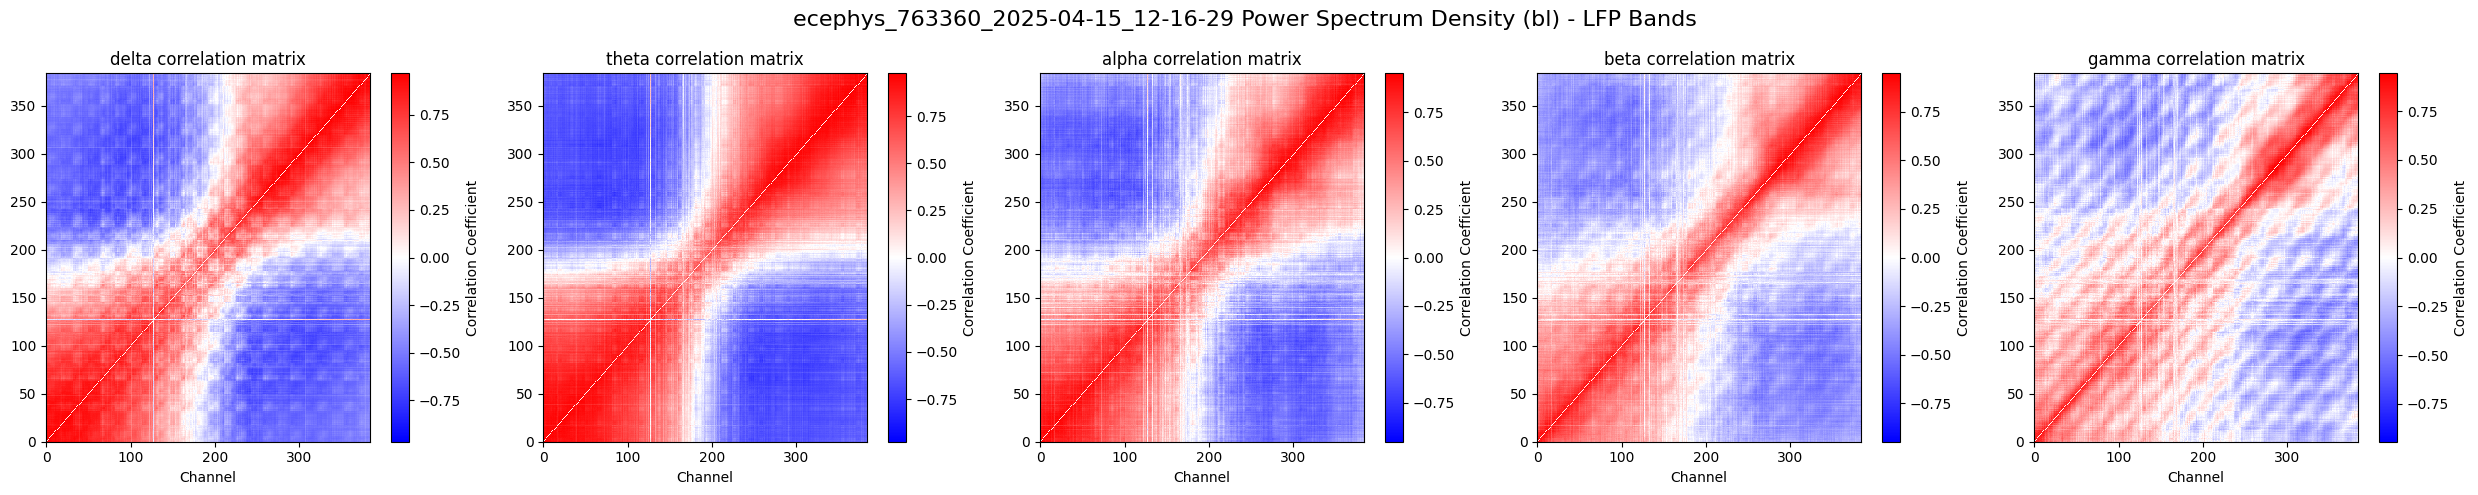

In [89]:
plot_ephys_corr_band('ecephys_763360_2025-04-15_12-16-29', probe='2', data_type='curated')

/opt/conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

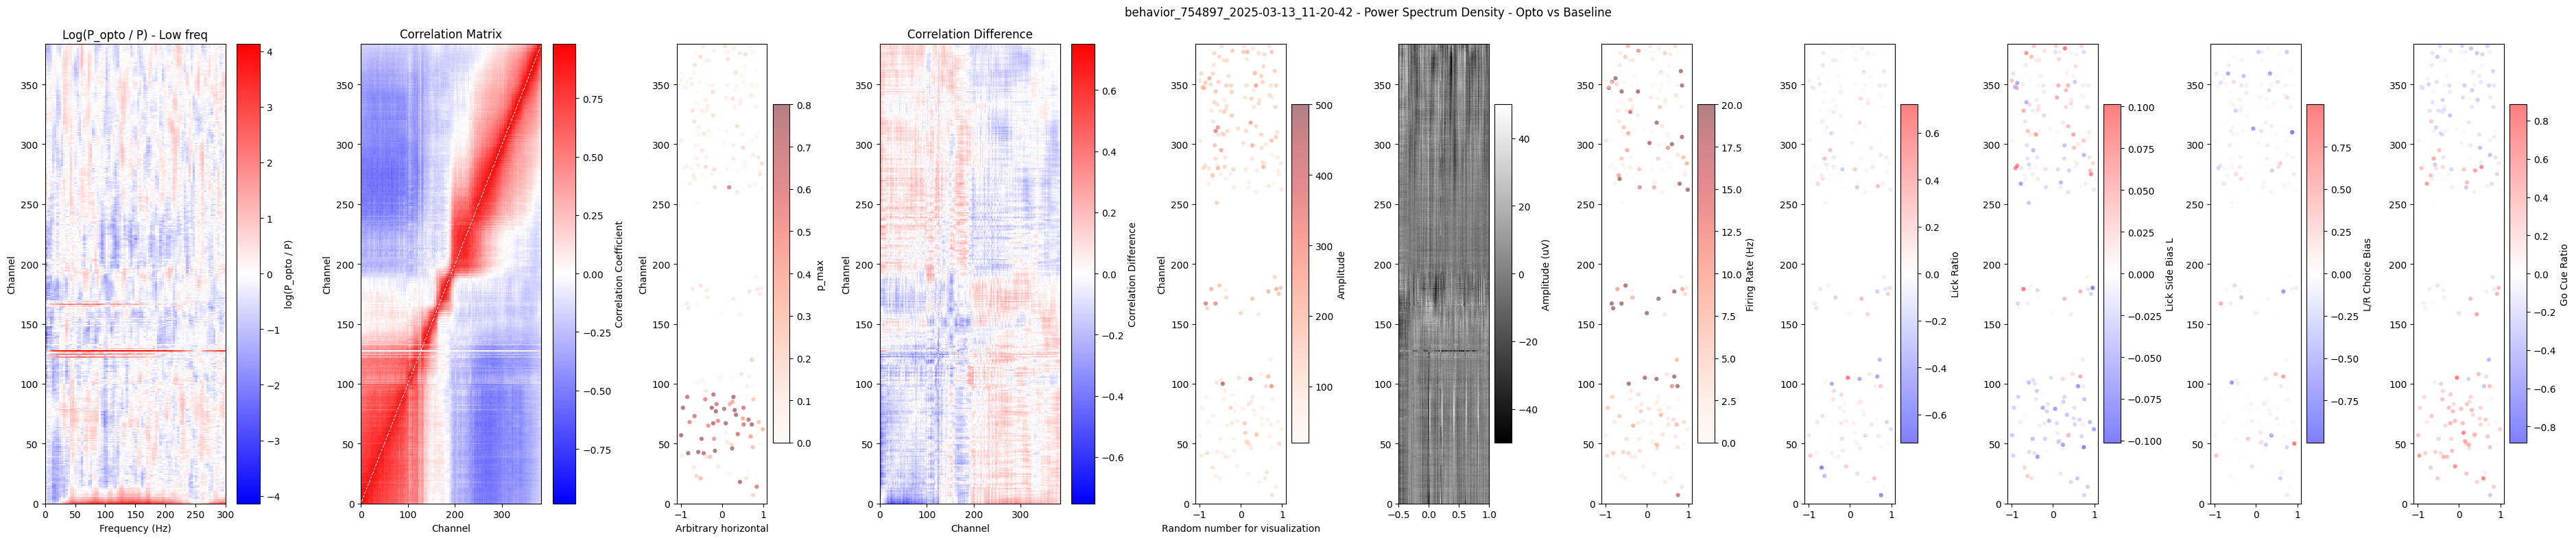

In [41]:
plot_ephys_probe('behavior_754897_2025-03-13_11-20-42', data_type='curated', probe='2')

In [90]:
session_assets = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
session_list = session_assets['session_id']
probe_list = session_assets['probe']
probe_list = [probe for probe, session in zip(probe_list, session_list) if isinstance(session, str)]
session_list = [session for session in session_list if isinstance(session, str)]    

In [91]:
from joblib import Parallel, delayed
data_type = 'curated'
def process(session, data_type, probe): 
    print(f'Starting {session}')
    session_dir = session_dirs(session)
    # if os.path.exists(os.path.join(session_dir['beh_fig_dir'], f'{session}.nwb')):
    print(session_dir[f'curated_dir_{data_type}'])
    if session_dir[f'curated_dir_{data_type}'] is not None:
        try:
            # plot_ephys_probe(session, data_type=data_type, probe=probe) 
            plot_ephys_corr_band(session, 
                    data_type='curated', 
                    probe = probe)
            plt.close('all')
            print(f'Finished {session}')
        except:
            print(f'Error processing {session}')
            plt.close('all')
    else: 
        print(f'No curated data found for {session}') 
    # elif session\_dir['curated_dir_raw'] is not None:
    #     data_type = 'raw' 
    #     opto_tagging_df_sess = opto_plotting_session(session, data_type, target, resp_thresh=resp_thresh, lat_thresh=lat_thresh, target_unit_ids= None, plot = True, save=True)
Parallel(n_jobs=4)(delayed(process)(session, data_type, probe) for session, probe in zip(session_list[:17], probe_list[:17]))
# # process('behavior_754897_2025-03-13_11-20-42', data_type)
# for session, probe in zip(session_list, probe_list):
#     process(session, data_type, probe)
#     plt.close('all')

In [45]:
# move all psd mean and opto to ephys_combined folder's subfolders mean and opto
session_assets = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
session_list = session_assets['session_id']
session_list = [session for session in session_list if isinstance(session, str)]   

bl_dir = '/root/capsule/scratch/combined/ephys_combined/bl'
opto_dir = '/root/capsule/scratch/combined/ephys_combined/opto'
cmp_dir = '/root/capsule/scratch/combined/ephys_combined/compare'
band_corr_dir = '/root/capsule/scratch/combined/ephys_combined/band_corr'
shutil.rmtree(path=bl_dir, ignore_errors=True)
shutil.rmtree(path=opto_dir, ignore_errors=True)
shutil.rmtree(path=cmp_dir, ignore_errors=True)
shutil.rmtree(path=band_corr_dir, ignore_errors=True)
os.mkdir(path=bl_dir)
os.mkdir(path=opto_dir)
os.mkdir(path=cmp_dir)
os.mkdir(path=band_corr_dir)

data_type = 'curated'
for session in session_list:
    session_dir = session_dirs(session)
    if os.path.exists(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_power_spectrum_density_bl.png')):
        print(f'Processing {session}...')
        curr_file = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_power_spectrum_density_bl.png')
        target_file = os.path.join(bl_dir, f'{session}_bl.png')
        shutil.copy(curr_file, target_file)

        curr_file = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_power_spectrum_density_opto.png')
        target_file = os.path.join(opto_dir, f'{session}_opto.png')
        shutil.copy(curr_file, target_file)
        
        curr_file = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_power_spectrum_density_opto_vs_baseline.png')
        target_file = os.path.join(cmp_dir, f'{session}_opto_vs_baseline.png')
        shutil.copy(curr_file, target_file)

        curr_file = os.path.join(os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_cross_corr_LFP_bands.png'))
        target_file = os.path.join(band_corr_dir, f'{session}_cross_corr_LFP_bands.png')
        shutil.copy(curr_file, target_file)
    else:
        print(f'Skipping {session} as it does not have the required files')
        

Processing ecephys_713854_2024-03-05_12-01-40...
Processing ecephys_713854_2024-03-05_13-01-09...
Processing ecephys_713854_2024-03-05_13-31-20...
Processing ecephys_717120_2024-03-06_12-23-53...
Processing ecephys_717120_2024-03-06_12-54-27...
Processing ecephys_717120_2024-03-07_12-12-02...
There are multiple recordings in the curated nwb directory. Picked one with units.
Skipping ecephys_713854_2024-03-08_14-54-25 as it does not have the required files
Processing ecephys_713854_2024-03-08_15-43-01...
Processing ecephys_713854_2024-03-08_16-20-33...
There is no nwb file in the curated directory.
Skipping ecephys_713854_2024-03-08_17-15-58 as it does not have the required files
Processing ecephys_684930_2023-09-27_10-04-04...
Processing ecephys_684930_2023-09-28_11-45-27...
Processing ecephys_684930_2023-09-28_12-44-15...
Processing ecephys_687697_2023-09-15_11-30-06...
Processing ecephys_687697_2023-09-15_12-36-06...
Processing ecephys_691893_2023-10-05_12-46-57...
Processing ecephys

In [46]:
combine_pdf_big(opto_dir, os.path.join('/root/capsule/scratch/combined/ephys_combined', 'opto_combined.pdf'))
combine_pdf_big(bl_dir, os.path.join('/root/capsule/scratch/combined/ephys_combined', 'bl_combined.pdf'))
combine_pdf_big(cmp_dir, os.path.join('/root/capsule/scratch/combined/ephys_combined', 'compare_combined.pdf'))
combine_pdf_big(band_corr_dir, os.path.join('/root/capsule/scratch/combined/ephys_combined', 'band_corr_combined.pdf'))

Processing 67 files in /root/capsule/scratch/combined/ephys_combined/opto
Combined PDF saved as: /root/capsule/scratch/combined/ephys_combined/opto_combined.pdf
Processing 67 files in /root/capsule/scratch/combined/ephys_combined/bl
Combined PDF saved as: /root/capsule/scratch/combined/ephys_combined/bl_combined.pdf
Processing 67 files in /root/capsule/scratch/combined/ephys_combined/compare
Combined PDF saved as: /root/capsule/scratch/combined/ephys_combined/compare_combined.pdf
Processing 67 files in /root/capsule/scratch/combined/ephys_combined/band_corr
Combined PDF saved as: /root/capsule/scratch/combined/ephys_combined/band_corr_combined.pdf


In [10]:
# plot LFP after opto stimulation
session = 'behavior_754897_2025-03-13_11-20-42'
session_dir = session_dirs(session)
data_type = 'curated'
probe = '2.0'
ili_thresh = 1

unit_tbl = get_unit_tbl(session, data_type)
nwb = load_nwb_from_filename(session_dir['nwb_beh'])
lick_L = nwb.acquisition['left_lick_time'].timestamps[:]
lick_R = nwb.acquisition['right_lick_time'].timestamps[:]
# combine L and R
licks = np.concatenate((lick_L, lick_R))
licks = np.sort(licks, axis=0)

# find train starts
train_starts = licks[np.where(np.diff(licks) > ili_thresh)[0] + 1]
lick_ratio = np.full(len(curr_unit_tbl), np.nan, dtype=float)

for unit_ind, unit in enumerate(curr_unit_tbl['unit'].values):
    spike_times = unit_tbl[unit_tbl['unit_id'] == unit]['spike_times'].values[0]
    df_bl = align.to_events(spike_times, train_starts, (-1, 0), return_df=True)
    df_lick = align.to_events(spike_times, train_starts, (0, 0.5), return_df=True)
    bl_counts = np.zeros(len(train_starts))
    resp_counts = np.zeros(len(train_starts))
    for i in range(len(train_starts)):
        bl_counts[i] = len(df_bl[df_bl['event_index'] == i])/1
        resp_counts[i] = len(df_lick[df_lick['event_index'] == i])/0.5
    lick_ratio[unit_ind] = np.mean((resp_counts-bl_counts) / (resp_counts + bl_counts + 1e-6))

FileNotFoundError: /root/capsule/scratch/784803/behavior_784803_2025-07-03/behavior/behavior_784803_2025-07-03.nwb

In [159]:
lick_ratio[-1]

np.float64(-0.07794189332750584)